# Práctica 1 Hadoop - MapReduce + Hive

In [1]:
import os

# nos vamos a esa carpeta y comprobamos donde estamos
os.chdir("/media/notebooks/practica1")
! pwd

/media/notebooks/practica1


Creamos una carpeta para los ejercicios en hdfs y subimos los ficheros de datos

In [147]:
#! hdfs dfs -mkdir /practica1
! hdfs dfs -mkdir /practica1/ejercicio1
! hdfs dfs -put /media/notebooks/practica1/*.csv /practica1
! hdfs dfs -ls /practica1/

mkdir: `/practica1/ejercicio1': File exists
Found 5 items
-rw-r--r--   3 root supergroup          0 2024-11-20 17:10 /practica1/archivo_seleccionado.csv
-rw-r--r--   3 root supergroup       1289 2024-11-20 17:10 /practica1/clients.csv
-rw-r--r--   3 root supergroup          0 2024-11-20 17:10 /practica1/convocatorias-2020.csv
-rw-r--r--   3 root supergroup       4120 2024-11-20 17:10 /practica1/countries.csv
drwxr-xr-x   - root supergroup          0 2024-11-20 17:09 /practica1/ejercicio1


In [160]:
! hdfs dfs -cat /practica1/ejercicio1/clients.csv | head -n 2

Bertram Pearcy  ,bueno,SO
Steven Ulman  ,regular,ZA


In [166]:
! hdfs dfs -cat /practica1/ejercicio1/convocatorias-2020.csv | head -n 1

40/51-0159-LPR19,381,381 - Estado Mayor General de La Fuerza Aérea,40,Departamento Contrataciones Córdoba - UOC 40/51,Licitacion Privada,Sin Modalidad,,2019,02/01/2020 08:00:00 a.m.,10/01/2020 10:00:00 a.m.,Única,Nacional,“Adquisición de Elementos de Librería para el HOSPITAL AERONÁUTICO CÓRDOBA,“Adquisición de Elementos de Librería para el HOSPITAL AERONÁUTICO CÓRDOBA,1957142.84,Proceso de Compra
cat: Unable to write to output stream.


In [168]:
# Mapeo código-nombre de pais
! hdfs dfs -cat /practica1/ejercicio1/countries.csv | head -n 3

Name,Code
Afghanistan,AF
Åland Islands,AX


## Ejercicio 1.1: Contador de clientes valorados por países.
Cuántos clientes con valoración “bueno” hay en cada país.

**Diseño del programa**

Como mínimo sería necesario incluir los pasos de map y de reduce. Sin embargo, sería posible optimizar el proceso añadiendo también un combiner que traslade parte del trabajo de reducción a los nodos. Esto sería especialmente útil con cargas mayores de trabajo, pero lo vamos a aplicar en este caso.

Es necesario hacer un proceso de mapeo de los códigos de país con los nombres de los países. Para esto se puede considerar varias opciones, la primera es distribuir el archivo countries.csv en el cluster y aplicarle un mapper especializado en paralelo al mapper que ya le estaríamos aplicando a los datos de trabajo. Esta sería la opción ideal si el archivo de mapeo es muy grande. Otra opción, quizás la óptima, sería aplicar el mapeo de países al final del proceso, después de la reducción. Sin embargo, el ejercicio pide que la salida del proceso map-reduce presente los nombres de los países y no sus códigos. 

Por este motivo, en este trabajo lo que se hará es aplicar dicho mapeo dentro del proceso de reducción, distribuyendo previamente el archivo countries.csv en "caché distribuído". El caché distribuído guarda una copia del archivo afectado en cada uno de los nodos que participan en el proceso MapReduce. De esta manera cada nodo reducer dispondrá de una copia local del archivo para realizar la conversión de código a nombre de país. Esta opción es recomendable únicamente cuando el archivo cargado en memoria es pequeño, como es este caso. La elección de aplicar la conversión de codigos en la etapa reduce se debe a que, en general, habrá menor cantidad de nodos implicados en este proceso que en el de mapping. Además, los datos habrán sido reducidos al agregarse los datos intermedios. Ambos hechos hacen que la cantidad de datos que pasan por el proceso de conversión sea menor y se mejore la eficiencia.

Resumidamente, el flujo de datos es el siguiente:
- La entrada del mapper es cada línea del archivo clients
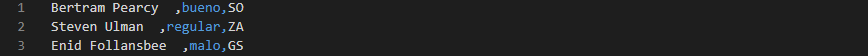

- El mapper filtra en cada datanode (sobre la porción de datos que contiene) las líneas con opinión "bueno" y devuelve pares clave-valor de la forma (código de país)-(contador con el número 1)

 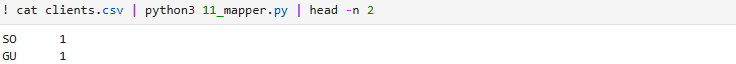

- El combiner en cada datanode recibe estas líneas y agrega las cantidades en el contador por cada código de país distinto, devolviendo pares (código de país)-(contador agregado)

- Los datos procedentes de los combiners en los datanodes son distribuidos en los diferentes reducers mediante el proceso de shuffle & sort ordenados y agrupados en función de sus claves.

- Finalmente, en los nodos de agregación se reciben estos pares clave-valor intermedios, donde se vuelven a agregar las cantidades de los contadores, se realiza la "traducción" de los códigos de país mediante un diccionario y se devuelve los nuevos pares (país)-(contador agregado) ordenados por país.

Creamos scripts con los procesos de map, combine y reduce.

In [4]:
%%writefile 11_mapper.py
#!/usr/bin/env python3

# Este mapper devuelve por cada línea con opinión positiva, el código de país y un 1

import sys

# entrada estandar STDIN
for linea in sys.stdin:
    
    # eliminamos espacios y dividimos cada linea en palabras
    campos = linea.strip().split(',')
    opinion, pais = campos[1], campos[2]

    if opinion == 'bueno':
        # cada palabra la escribimos junto con un 1 y esta es la entrada del combiner
        print ('%s\t%s' % (pais, 1))

Overwriting 11_mapper.py


In [71]:
%%writefile 11_combiner.py
#!/usr/bin/env python3

from collections import defaultdict
import sys

# Ulizamos un diccionario para las palabras con un entero como valor
contador_por_pais = defaultdict(int)

# Sumamos las apariciones parciales (en este caso 1) al valor de cada clave (país) cuando esta aparece en una línea
for linea in sys.stdin:
    codigo, numero = linea.strip().split('\t')
    contador_por_pais[codigo] += int(numero)

# Salida: por cada pais el numero total de apariciones
for codigo in contador_por_pais.keys():
    print ('%s\t%s' % (codigo, contador_por_pais[codigo]))  

Overwriting 11_combiner.py


In [140]:
%%writefile 11_reducer.py
#!/usr/bin/env python3

from collections import defaultdict
import sys

# 1. Carga del mapeo codigo:pais:
def carga_countries(file):
    mapping = {}
    with open(file, 'r') as f:
        next(f)  # Avanza una línea para saltar el header
        for line in f:
            campos = line.strip().split(',')
            pais, codigo = (",".join(campos[:-1]), campos[-1]) # Unimos los campos separados por la coma del nombre de algunos paises
            mapping[codigo] = pais
    return mapping


# 2. Reducer
mapping = carga_countries("countries.csv")

# Ulizamos un diccionario para las palabras con un entero como valor
contador_por_pais = defaultdict(int)

# Sumamos las apariciones parciales (en este caso 1) al valor de cada clave (país) cuando esta aparece en una línea
for linea in sys.stdin:
    codigo, numero = linea.strip().split('\t')
    contador_por_pais[codigo] += int(numero)

# Mapeamos los codigos con los nombres de los paises
convert_contador = {mapping[codigo]: contador_por_pais[codigo] for codigo in contador_por_pais.keys()}

# escribimos por cada pais el numero total de apariciones
for pais, numero in sorted(convert_contador.items(), key=lambda item: item[0]):
    print ('%s\t%s' % (pais, numero))

Overwriting 11_reducer.py


In [142]:
! hadoop jar /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.4.0.jar \
-files 11_mapper.py,11_combiner.py,11_reducer.py,countries.csv \
-mapper 11_mapper.py \
-combiner 11_combiner.py \
-reducer 11_reducer.py \
-input /practica1/clients.csv \
-output /practica1/11_salida

packageJobJar: [/tmp/hadoop-unjar9130850184786831685/] [] /tmp/streamjob2890519559786905807.jar tmpDir=null
2024-11-15 20:15:04,641 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.29.0.3:8032
2024-11-15 20:15:04,779 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.29.0.3:8032
2024-11-15 20:15:05,026 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1731686121000_0021
2024-11-15 20:15:05,542 INFO mapred.FileInputFormat: Total input files to process : 1
2024-11-15 20:15:05,610 INFO mapreduce.JobSubmitter: number of splits:2
2024-11-15 20:15:05,696 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1731686121000_0021
2024-11-15 20:15:05,696 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-11-15 20:15:05,861 INFO conf.Configuration: resource-types.xml not found
2024-11-15 20:15:05,861 INFO resource.ResourceUtils

Ejecutamos el trabajo MapReduce

In [154]:
! hadoop jar /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.4.0.jar \
-D mapreduce.output.fileoutputformat.compress=false \
-files 11_mapper.py,11_combiner.py,11_reducer.py,countries.csv \
-mapper 11_mapper.py \
-combiner 11_combiner.py \
-reducer 11_reducer.py \
-input /practica1/ejercicio1/clients.csv \
-output /practica1/ejercicio1/112_salida

packageJobJar: [/tmp/hadoop-unjar6951514998334055932/] [] /tmp/streamjob6969003701553846985.jar tmpDir=null
2024-11-16 09:28:20,488 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.29.0.3:8032
2024-11-16 09:28:20,671 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.29.0.3:8032
2024-11-16 09:28:20,896 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1731686121000_0022
2024-11-16 09:28:21,769 INFO mapred.FileInputFormat: Total input files to process : 1
2024-11-16 09:28:22,091 INFO mapreduce.JobSubmitter: number of splits:2
2024-11-16 09:28:22,322 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1731686121000_0022
2024-11-16 09:28:22,322 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-11-16 09:28:22,481 INFO conf.Configuration: resource-types.xml not found
2024-11-16 09:28:22,481 INFO resource.ResourceUtils

IOStream.flush timed out


2024-11-16 09:28:47,625 INFO mapreduce.Job:  map 100% reduce 0%
2024-11-16 09:28:52,652 INFO mapreduce.Job:  map 100% reduce 100%
2024-11-16 09:28:52,659 INFO mapreduce.Job: Job job_1731686121000_0022 completed successfully
2024-11-16 09:28:52,787 INFO mapreduce.Job: Counters: 54
	File System Counters
		FILE: Number of bytes read=104
		FILE: Number of bytes written=945567
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
		HDFS: Number of bytes read=2122
		HDFS: Number of bytes written=163
		HDFS: Number of read operations=11
		HDFS: Number of large read operations=0
		HDFS: Number of write operations=2
		HDFS: Number of bytes read erasure-coded=0
	Job Counters 
		Launched map tasks=2
		Launched reduce tasks=1
		Data-local map tasks=2
		Total time spent by all maps in occupied slots (ms)=29328
		Total time spent by all reduces in occupied slots (ms)=2615
		Total time spent by all map tasks (ms)=29328
		Total time spent by

En este caso el número de nodos tanto de mapeo como de reducción es de 1, con lo que esto no produciría una cambio significativo en el tiempo de traducción de los códigos de país.

Veamos el resultado

In [143]:
!hadoop fs -tail /practica1/ejercicio1/11_salida/part-00000

Canada	1
Guam	3
Guinea	1
Portugal	1
Qatar	1
Somalia	1
South Africa	1
South Georgia and the South Sandwich Islands	1
South Sudan	1
Spain	3
Turkey	1
United States	1


## Ejercicio 1.2: País con mejores clientes
El objetivo es determinar el país en el que hay más clientes valorados como “bueno”.

**Diseño del programa**

En este caso bastaría con modificar el job de reducción para buscar el valor máximo de valoraciones buenas. 

Los pasos del proceso MapReduce serían los mismos que en apartado 1 y el flujo de datos sería el siguiente

- La entrada del mapper es cada línea del archivo clients

- El mapper filtra en cada datanode (sobre la porción de datos que contiene) las líneas con opinión "bueno" y devuelve pares clave-valor de la forma (código de país)-(contador con el número 1)

- El combiner en cada datanode recibe estas líneas y agrega las cantidades en el contador por cada código de país distinto, devolviendo pares (código de país)-(contador agregado)

- Los datos procedentes de los combiners en los datanodes son distribuidos en los diferentes reducers mediante el proceso de shuffle & sort ordenados y agrupados en función de sus claves.

- Finalmente, en los nodos de agregación se reciben estos pares clave-valor intermedios, donde se vuelven a agregar las cantidades de los contadores, se realiza la "traducción" de los códigos de país y se busca entre los items del diccionario que contiene el número de valoraciones buenas por país aquel con mayor número. La salida es el par (país)-(contador agregado) correspondiente a dicho item.

In [163]:
%%writefile 12_reducer.py
#!/usr/bin/env python3

from collections import defaultdict
import sys

# 1. Carga del mapeo codigo:pais:
def carga_countries(file):
    mapping = {}
    with open(file, 'r') as f:
        next(f)  # Avanza una línea para saltar el header
        for line in f:
            campos = line.strip().split(',')
            pais, codigo = (",".join(campos[:-1]), campos[-1]) # Unimos los campos separados por la coma del nombre de algunos paises
            mapping[codigo] = pais
    return mapping


# 2. Reducer
mapping = carga_countries("countries.csv")

# Ulizamos un diccionario para las palabras con un entero como valor
contador_por_pais = defaultdict(int)

# Sumamos las apariciones parciales (en este caso 1) al valor de cada clave (país) cuando esta aparece en una línea
for linea in sys.stdin:
    codigo, numero = linea.strip().split('\t')
    contador_por_pais[codigo] += int(numero)

# Mapeamos los codigos con los nombres de los paises
convert_contador = {mapping[codigo]: contador_por_pais[codigo] for codigo in contador_por_pais.keys()}

# Calculamos el máximo de valoraciones "buenas"
pais, max_num = max(convert_contador.items(), key=lambda x: x[1])

# Salida
print ('%s\t%s' % (max_num, pais))

Overwriting 12_reducer.py


Ejecutamos el proceso MapReduce

In [44]:
! hadoop jar /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.4.0.jar \
-files 11_mapper.py,11_combiner.py,12_reducer.py,countries.csv \
-mapper 11_mapper.py \
-combiner 11_combiner.py \
-reducer 12_reducer.py \
-input /practica1/ejercicio1/clients.csv \
-output /practica1/ejercicio1/12_salida

packageJobJar: [/tmp/hadoop-unjar6234014231424442825/] [] /tmp/streamjob1808462849641502438.jar tmpDir=null
2024-11-15 17:41:17,563 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.29.0.3:8032
2024-11-15 17:41:17,721 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.29.0.3:8032
2024-11-15 17:41:17,941 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1731686121000_0008
2024-11-15 17:41:18,392 INFO mapred.FileInputFormat: Total input files to process : 1
2024-11-15 17:41:18,456 INFO mapreduce.JobSubmitter: number of splits:2
2024-11-15 17:41:18,546 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1731686121000_0008
2024-11-15 17:41:18,546 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-11-15 17:41:18,697 INFO conf.Configuration: resource-types.xml not found
2024-11-15 17:41:18,698 INFO resource.ResourceUtils

Y obtenemos el resultado

In [106]:
!hadoop fs -tail /practica1/ejercicio1/12_salida/part-00000

3	['Spain']


## Ejercicio 1.3: Mejorando el país con mejores clientes

Devolver todos los países empatados con el mayor número de buenos clientes.

**Diseño del programa**

De nuevo, hay que modificar el job de reducción para que devuelva todos los items del diccionario con el número máximo de valoraciones buenas. 

Los pasos del proceso MapReduce serían los mismos que en apartado 1 y el flujo de datos sería el siguiente

- La entrada del mapper es cada línea del archivo clients

- El mapper filtra en cada datanode (sobre la porción de datos que contiene) las líneas con opinión "bueno" y devuelve pares clave-valor de la forma (código de país)-(contador con el número 1)

- El combiner en cada datanode recibe estas líneas y agrega las cantidades en el contador por cada código de país distinto, devolviendo pares (código de país)-(contador agregado)

- Los datos procedentes de los combiners en los datanodes son distribuidos en los diferentes reducers mediante el proceso de shuffle & sort ordenados y agrupados en función de sus claves.

- Finalmente, en los nodos de agregación se reciben estos pares clave-valor intermedios, donde se vuelven a agregar las cantidades de los contadores y se realiza la "traducción" de los códigos de país. Luego se busca entre los items del diccionario que contiene el número de valoraciones buenas por país aquel con mayor número y se busca en el mismo diccionario todos los items con ese mismo valor. Se devuelve todos los pares (país)-(contador agregado) encontrados.

In [150]:
%%writefile 13_reducer.py
#!/usr/bin/env python3

from collections import defaultdict
import sys

# 1. Carga del mapeo codigo:pais:
def carga_countries(file):
    mapping = {}
    with open(file, 'r') as f:
        next(f)  # Avanza una línea para saltar el header
        for line in f:
            campos = line.strip().split(',')
            pais, codigo = (",".join(campos[:-1]), campos[-1]) # Unimos los campos separados por la coma del nombre de algunos paises
            mapping[codigo] = pais
    return mapping


# 2. Reducer
mapping = carga_countries("countries.csv")

# Ulizamos un diccionario para las palabras con un entero como valor
contador_por_pais = defaultdict(int)

# Sumamos las apariciones parciales (en este caso 1) al valor de cada clave (país) cuando esta aparece en una línea
for linea in sys.stdin:
    codigo, numero = linea.strip().split('\t')
    contador_por_pais[codigo] += int(numero)

# Mapeamos los codigos con los nombres de los paises
convert_contador = {mapping[codigo]: contador_por_pais[codigo] for codigo in contador_por_pais.keys()}

# Calculamos el máximo de opiniones "buenas"
pais, max_num = max(convert_contador.items(), key=lambda x: x[1])
for pais, num in sorted(convert_contador.items(), key=lambda item: item[0]):
    if num == max_num:
        print ('%s\t%s' % (num, pais))

Overwriting 13_reducer.py


In [103]:
! hadoop jar /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.4.0.jar \
-files 11_mapper.py,11_combiner.py,13_reducer.py,countries.csv \
-mapper 11_mapper.py \
-combiner 11_combiner.py \
-reducer 13_reducer.py \
-input /practica1/ejercicio1/clients.csv \
-output /practica1/ejercicio1/13_salida

packageJobJar: [/tmp/hadoop-unjar8180910531056673924/] [] /tmp/streamjob2273448452937181370.jar tmpDir=null
2024-11-15 19:05:52,029 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.29.0.3:8032
2024-11-15 19:05:52,152 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.29.0.3:8032
2024-11-15 19:05:52,323 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1731686121000_0018
2024-11-15 19:05:52,754 INFO mapred.FileInputFormat: Total input files to process : 1
2024-11-15 19:05:52,843 INFO mapreduce.JobSubmitter: number of splits:2
2024-11-15 19:05:52,948 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1731686121000_0018
2024-11-15 19:05:52,949 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-11-15 19:05:53,124 INFO conf.Configuration: resource-types.xml not found
2024-11-15 19:05:53,124 INFO resource.ResourceUtils

In [105]:
!hadoop fs -tail /practica1/ejercicio1/13_salida/part-00000

3	['Spain']
3	['Guam']


## Ejercicio 2:

Se crearán tablas lo más específicas posible, de modo que se optimicen las consultas. Al hacer esto, podemos aprovechar al máximo el particionamiento eligiendo las columnas adecuadas para cada tabla. Luego, en consultas complejas podemos recurrir a joins de estas tablas. También podemos optimizar estos joins mediante el bucketizado.

In [371]:
! hdfs dfs -put /media/notebooks/practica1/convocatorias-2020.csv /practica1

Visualizamos los datos del archivo que vamos a usar 

In [183]:
import pandas as pd

df = pd.read_csv("convocatorias-2020.csv", header=None)
df.head(2)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,40/51-0159-LPR19,381,381 - Estado Mayor General de La Fuerza Aérea,40,Departamento Contrataciones Córdoba - UOC 40/51,Licitacion Privada,Sin Modalidad,NaN,2019,02/01/2020 08:00:00 a.m.,10/01/2020 10:00:00 a.m.,Única,Nacional,“Adquisición de Elementos de Librería para el ...,“Adquisición de Elementos de Librería para el ...,1957142.84,Proceso de Compra
1,22-0041-CDI19,250,250 - Caja de Retiros Jubilaciones y Pensiones...,22,22 - Dpto de Compras y Suministros - Caja de R...,Contratación Directa,Sin Modalidad,Apartado 1: Compulsa Abreviada Por Monto,2019,02/01/2020 12:00:00 p.m.,13/01/2020 09:00:00 a.m.,Única,Nacional,Servicio de seguridad de información sensible ...,Servicio de seguridad de información sensible ...,119915.25,Proceso de Compra


In [19]:
df_select = df[[5, 8, 2, 15, 12]]
df_select.head()

,5,8,2,15,12
0,Licitacion Privada,2019,381 - Estado Mayor General de La Fuerza Aérea,1957142.84,Nacional
1,Contratación Directa,2019,250 - Caja de Retiros Jubilaciones y Pensiones...,119915.25,Nacional
2,Contratación Directa,2019,381 - Estado Mayor General de La Fuerza Aérea,99000.00,Nacional
3,Contratación Directa,2019,116 - Biblioteca Nacional,1450050.00,Nacional
4,Contratación Directa,2020,604 - Dirección Nacional de Vialidad,684000.00,Nacional


In [29]:
print("Tipo de Procedimiento: Hay un total de {} valores posibles".format(df_select[5].nunique()))
print("Ejercicio: Hay un total de {} valores posibles".format(df_select[8].nunique()))
print("Descripcion SAF: Hay un total de {} valores posibles".format(df_select[2].nunique()))
print("Alcance: Hay un total de {} valores posibles".format(df_select[12].nunique()))

Tipo de Procedimiento: Hay un total de 6 valores posibles
Ejercicio: Hay un total de 3 valores posibles
Descripcion SAF: Hay un total de 125 valores posibles
Alcance: Hay un total de 2 valores posibles


Voy a utilizar tablas internas ya que el particionado es más sencillo en estas. Para realizar particiones en tablas externas, se deben subir los
archivos ya particionados adecuadamente a hdfs.

Crearemos una tabla que temporal que contenga todos los datos del csv. De esa tabla extraeremos otras con columnas seleccionadas para llevar a cabo cada query de forma optima.

In [342]:
%%writefile tabla_total.hql
CREATE TABLE tabla_total(
    Id STRING,
    NroSaf INT,
    DescripcionSaf STRING,
    NroUoc INT,
    Descripcion_Uoc STRING,
    TipoProcedimiento STRING,
    Modalidad STRING,
    ApartadoDirecta STRING,
    Ejercicio INT,
    FechaPublicacion STRING,
    FechaApertura STRING,
    Etapa STRING,
    Alcance STRING,
    NombreProcedimiento STRING,
    ObjetoProcedimiento STRING,
    MontoEstimado FLOAT,
    TipoOperacion STRING
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/practica1/';

Overwriting tabla_total.hql


In [350]:
# ejecucion del fichero hql mediante beeline
!beeline -u "jdbc:hive2://" -f tabla_total.hql

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

In [372]:
# carga datos 2021 
!beeline -u "jdbc:hive2://" -e \
"LOAD DATA INPATH '/practica1/convocatorias-2020.csv'  \
INTO TABLE tabla_total;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

In [373]:
!beeline -u "jdbc:hive2://" -e \
"SELECT * FROM tabla_total \
LIMIT 3;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

Creamos el resto de las tablas

In [358]:
%%writefile tabla_procedimiento_ejercicio.hql
CREATE TABLE IF NOT EXISTS tabla_procedimiento_ejercicio(
    ID STRING
)
PARTITIONED BY (Ejercicio Int, Tipo_Procedimiento STRING)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/practica1/';

Overwriting tabla_procedimiento_ejercicio.hql


La bucketización ayuda a reducir el número de valores únicos por bucket, lo que acelera el procesado de la operación de conteo de valores únicos.

In [252]:
%%writefile tabla_saf.hql
CREATE TABLE IF NOT EXISTS tabla_saf(
    ID STRING,
    Descripcion_SAF STRING
)
CLUSTERED BY (Descripcion_SAF) INTO 5 BUCKETS;
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/practica1/';

Overwriting tabla_saf.hql


Bucketizar los datos por una columna que esté relacionada con el cálculo puede acelerar las consultas.

In [260]:
%%writefile tabla_monto_alcance.hql
CREATE TABLE IF NOT EXISTS tabla_monto_alcance(
    ID STRING,
    Monto_Estimado FLOAT
)
PARTITIONED BY (alcance STRING)
CLUSTERED BY (Monto_Estimado) INTO 10 BUCKETS;
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/practica1/';

Overwriting tabla_monto_alcance.hql


In [356]:
# Si queremos resetear las tablas antes de crearlas

#!beeline -u "jdbc:hive2://" -e "drop table tabla_procedimiento_ejercicio;"
# !beeline -u "jdbc:hive2://" -e "drop table alcance;"
# !beeline -u "jdbc:hive2://" -e "drop table ejercicio;"
# !beeline -u "jdbc:hive2://" -e "drop table monto;"
# !beeline -u "jdbc:hive2://" -e "drop table saf;"
# !beeline -u "jdbc:hive2://" -e "drop table stars;"
#!beeline -u "jdbc:hive2://" -e "drop table tabla_total;"

In [261]:
# ejecucion del fichero hql mediante beeline
!beeline -u "jdbc:hive2://" -f tabla_procedimiento_ejercicio.hql
!beeline -u "jdbc:hive2://" -f tabla_saf.hql
!beeline -u "jdbc:hive2://" -f tabla_monto_alcance.hql

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

In [246]:
# # ejecucion del fichero hql mediante beeline
# !beeline -u "jdbc:hive2://" -f tabla_procedimiento.hql
# !beeline -u "jdbc:hive2://" -f tabla_procedimiento.hql
# !beeline -u "jdbc:hive2://" -f tabla_ejercicio.hql
# !beeline -u "jdbc:hive2://" -f tabla_saf.hql
# !beeline -u "jdbc:hive2://" -f tabla_monto.hql
# !beeline -u "jdbc:hive2://" -f tabla_alcance.hql

In [364]:
#! beeline -u "jdbc:hive2://" -e "show tables;"

**Poblamos las tablas**

In [374]:
! beeline -u "jdbc:hive2://" -e \
"INSERT INTO TABLE tabla_procedimiento_ejercicio (ID, Ejercicio, Tipo_Procedimiento) \
SELECT Id, Ejercicio, TipoProcedimiento FROM tabla_total;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

In [376]:
!beeline -u "jdbc:hive2://" -e "SELECT * FROM tabla_procedimiento_ejercicio \
LIMIT 3;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

In [310]:
! beeline -u "jdbc:hive2://" -e \
"INSERT INTO TABLE tabla_saf (ID, Descripcion_SAF) \
SELECT Id, DescripcionSaf FROM tabla_total;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

In [312]:
!beeline -u "jdbc:hive2://" -e "SELECT * FROM tabla_saf \
LIMIT 3;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

In [301]:
! beeline -u "jdbc:hive2://" -e \
"INSERT INTO TABLE tabla_monto_alcance (ID, Monto_Estimado, alcance) \
SELECT Id, MontoEstimado, Alcance FROM tabla_total;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

In [302]:
!beeline -u "jdbc:hive2://" -e "SELECT * FROM tabla_monto_alcance \
LIMIT 3;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

**QUERIES**

In [377]:
!beeline -u "jdbc:hive2://" -e "SELECT * FROM tabla_procedimiento_ejercicio \
WHERE  Tipo_Procedimiento = 'Contratación Directa' \
LIMIT 5;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

In [378]:
!beeline -u "jdbc:hive2://" -e "SELECT * FROM tabla_procedimiento_ejercicio \
WHERE Tipo_Procedimiento = 'Contratación Directa' AND Ejercicio < 2020 \
LIMIT 5;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

In [387]:
!beeline -u "jdbc:hive2://" -e "SELECT COUNT(DISTINCT(Descripcion_SAF)) AS Tipos_de_SAF FROM tabla_saf;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

In [391]:
!beeline -u "jdbc:hive2://" -e "SELECT MAX(Monto_Estimado) AS Max_monto FROM tabla_monto_alcance;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session

In [ ]:
tabla_monto_alcance (ID, Monto_Estimado, alcance)

In [397]:
!beeline -u "jdbc:hive2://" -e "SELECT alcance, CAST((AVG(Monto_Estimado)) AS DECIMAL(20, 2)) AS Monto_promedio FROM tabla_monto_alcance \
GROUP BY alcance;"

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hive/lib/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Connecting to jdbc:hive2://
Hive Session